<a href="https://colab.research.google.com/github/antomys/Coursera_Related_Projects/blob/master/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mimg
# plotly
import plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

import tensorflow as tf
from plotly.graph_objs import *
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras import layers
from keras import models
from keras import optimizers

#This is for confusion_matrixes. We need to update mlxtend because this crap
# Has bug in it's default versuin 0.14. Probably 0.18 will work out
import mlxtend
                                                          
print(mlxtend.__version__) 

!pip install mlxtend --upgrade --no-deps

print(mlxtend.__version__) 

0.18.0
Requirement already up-to-date: mlxtend in /usr/local/lib/python3.7/dist-packages (0.18.0)
0.18.0


In [3]:
# original dataset folder, you can see above
input_path = Path('/content/drive/MyDrive/data')
flowers_path = input_path / 'valid'

In [4]:
# Each species of flower is contained in a separate folder. Get all the sub directories
flower_types = os.listdir(flowers_path)
print("Types of flowers found: ", len(flower_types))
print("Categories of flowers: ", flower_types)

Types of flowers found:  5
Categories of flowers:  ['sunflower', 'rose', 'tulip', 'daisy', 'dandelion']


In [5]:
# A list that is going to contain tuples: (species of the flower, corresponding image path)
flowers = []

for species in flower_types:
    # Get all the file names
    all_flowers = os.listdir(flowers_path / species)
    # Add them to the list
    for flower in all_flowers:
        flowers.append((species, str(flowers_path /species) + '/' + flower))

# Build a dataframe        
flowers = pd.DataFrame(data=flowers, columns=['category', 'image'], index=None)
flowers.head()

,category,image
0,sunflower,/content/drive/MyDrive/data/valid/sunflower/14...
1,sunflower,/content/drive/MyDrive/data/valid/sunflower/14...
2,sunflower,/content/drive/MyDrive/data/valid/sunflower/13...
3,sunflower,/content/drive/MyDrive/data/valid/sunflower/13...
4,sunflower,/content/drive/MyDrive/data/valid/sunflower/14...


In [6]:
flowers['image'][0]

'/content/drive/MyDrive/data/valid/sunflower/14925398441_107f3e0304_n.jpg'

In [7]:
# Let's check how many samples for each category are present
print("Total number of flowers in the dataset: ", len(flowers))
fl_count = flowers['category'].value_counts()
print("Flowers in each category: ")
print(fl_count)

Total number of flowers in the dataset:  3856
Flowers in each category: 
dandelion    975
tulip        894
rose         684
daisy        669
sunflower    634
Name: category, dtype: int64


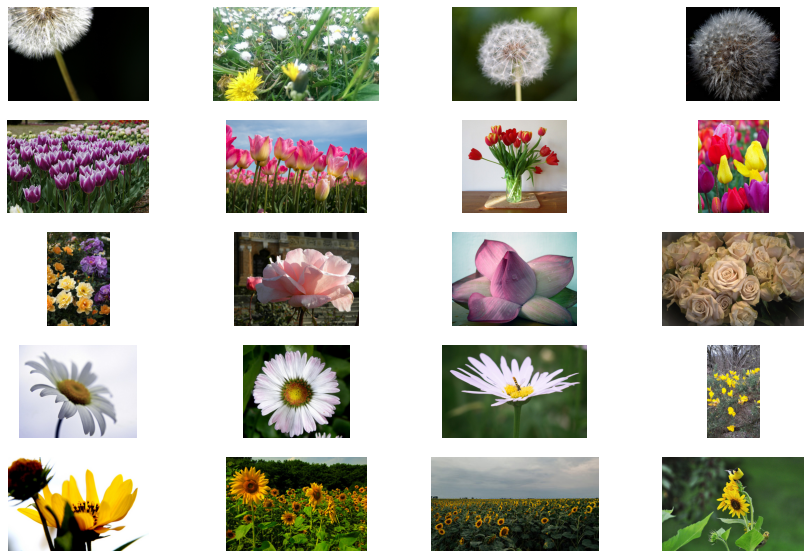

In [8]:
# Let's visualize some flowers from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].sample(4).values
    for sample in samples:
        random_samples.append(sample)

# Plot the samples
f, ax = plt.subplots(5,4, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//4, i%4].imshow(mimg.imread(random_samples[i]))
    ax[i//4, i%4].axis('off')
plt.show() 

In [9]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(240, 240, 3))

In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0     

In [11]:
base_dir = '/content/drive/MyDrive/data'
validation_dir = os.path.join(base_dir, 'train')
train_dir = os.path.join(base_dir, 'valid')

In [12]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
accuracies = []

In [13]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count, 5))

    generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory,
        target_size=(240, 240),
        batch_size = batch_size, 
        class_mode='categorical')

    i = 0

    print('Entering for loop...');

    
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [14]:
train_features, train_labels = extract_features(train_dir, 3853)
validation_features, validation_labels = extract_features(validation_dir, 500)

Found 3853 images belonging to 5 classes.
Entering for loop...
Found 500 images belonging to 5 classes.
Entering for loop...


In [15]:
train_features = np.reshape(train_features, (3853, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (500, 7 * 7 * 512))

In [16]:
model = models.Sequential()
model.add(layers.Dense(2048, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 6

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [19]:
history = model.fit(train_features, train_labels,
                    epochs=25,
                    batch_size=16,
                    validation_data=(validation_features, validation_labels))

Epoch 1/25
241/241 [==============================] - 7s 27ms/step - loss: 1.9797 - acc: 0.2972 - val_loss: 1.0739 - val_acc: 0.6420
Epoch 2/25
241/241 [==============================] - 6s 25ms/step - loss: 1.2812 - acc: 0.4960 - val_loss: 0.8915 - val_acc: 0.6800
Epoch 3/25
241/241 [==============================] - 6s 25ms/step - loss: 0.9797 - acc: 0.6252 - val_loss: 0.8144 - val_acc: 0.6920
Epoch 4/25
241/241 [==============================] - 6s 25ms/step - loss: 0.8835 - acc: 0.6705 - val_loss: 0.7496 - val_acc: 0.7420
Epoch 5/25
241/241 [==============================] - 6s 25ms/step - loss: 0.7458 - acc: 0.7401 - val_loss: 0.6869 - val_acc: 0.7420
Epoch 6/25
241/241 [==============================] - 6s 25ms/step - loss: 0.6151 - acc: 0.7797 - val_loss: 0.6847 - val_acc: 0.7500
Epoch 7/25
241/241 [==============================] - 6s 25ms/step - loss: 0.5671 - acc: 0.8019 - val_loss: 0.7779 - val_acc: 0.7320
Epoch 8/25
241/241 [==============================] - 6s 25ms/step - 

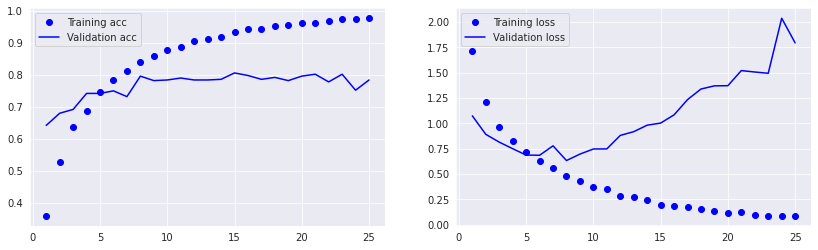

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [21]:
model_1_val = val_acc[-1]
accuracies.append(model_1_val)
print("Validation Accuracy: ", model_1_val)

Validation Accuracy:  0.7839999794960022


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f342e0b5e10>)

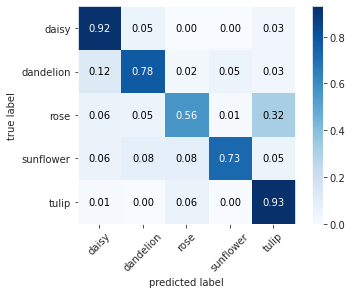

In [26]:
from mlxtend.plotting import plot_confusion_matrix
y_pred=model.predict_classes(validation_features)
con_mat = tf.math.confusion_matrix(validation_labels.argmax(1), y_pred)
con_mat = np.array(con_mat)
plot_confusion_matrix(conf_mat = con_mat, class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'],colorbar=True,
                                show_absolute=False,
                                show_normed=True)

WITH DA

In [27]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                

In [31]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/data/train',
        target_size=(240, 240),  # all images will be resized to 240x240
        batch_size=batch_size,
        class_mode='categorical')  # more than two classes

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/data/valid',
        target_size=(240, 240),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)

Found 500 images belonging to 5 classes.
Found 3853 images belonging to 5 classes.


In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

In [33]:
history = model.fit_generator(
          train_generator,
          epochs=30,
          validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
16/16 [==============================] - 39s 2s/step - loss: 1.9458 - acc: 0.1772 - val_loss: 1.5517 - val_acc: 0.3470
Epoch 2/30
16/16 [==============================] - 29s 2s/step - loss: 1.6854 - acc: 0.2290 - val_loss: 1.5256 - val_acc: 0.3740
Epoch 3/30
16/16 [==============================] - 29s 2s/step - loss: 1.6073 - acc: 0.2357 - val_loss: 1.4559 - val_acc: 0.4225
Epoch 4/30
16/16 [==============================] - 29s 2s/step - loss: 1.5270 - acc: 0.3275 - val_loss: 1.3369 - val_acc: 0.5424
Epoch 5/30
16/16 [==============================] - 29s 2s/step - loss: 1.3672 - acc: 0.4196 - val_loss: 1.1982 - val_acc: 0.5972
Epoch 6/30
16/16 [==============================] - 29s 2s/step - loss: 1.1913 - acc: 0.5262 - val_loss: 1.0949 - val_acc: 0.6076
Epoch 7/30
16/16 [==============================] - 29s 2s/step - loss: 1.0740 - acc: 0.5698 - val_loss: 0.9473 - val_acc: 0.6631
Epoch 8/30
16/16 [==============================] - 29s 2s/step - loss: 0.9385 - acc: 0.61

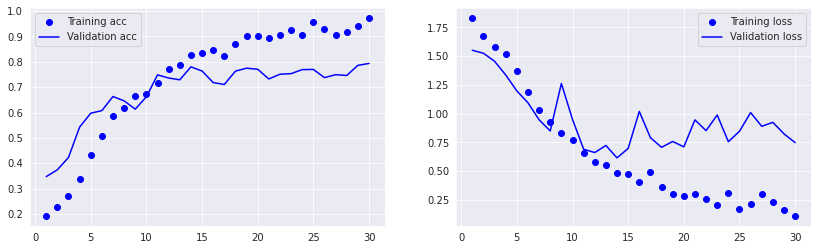

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [ ]:
model_2_val = val_acc[-1]
accuracies.append(model_2_val)
print("Validation Accuracy: ", model_2_val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f341a1b1050>)

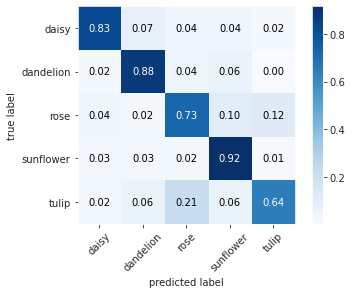

In [36]:
validation_generator.reset()
y_pred = model.predict_generator(validation_generator)
y_pred = y_pred.argmax(-1)
con_mat = tf.math.confusion_matrix(validation_generator.classes, y_pred)
con_mat = np.array(con_mat)
plot_confusion_matrix(conf_mat = con_mat, class_names = validation_generator.class_indices.keys(),colorbar=True,
                                show_absolute=False,
                                show_normed=True)

# Fine Tuning

In [37]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0     

In [38]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [39]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

In [46]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
10/10 [==============================] - 14s 1s/step - loss: 0.0358 - acc: 0.9773 - val_loss: 0.2588 - val_acc: 0.8438
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 0.0451 - acc: 0.9773 - val_loss: 0.2202 - val_acc: 0.8575
Epoch 3/30
10/10 [==============================] - 13s 1s/step - loss: 0.0430 - acc: 0.9773 - val_loss: 0.1859 - val_acc: 0.8788
Epoch 4/30
10/10 [==============================] - 13s 1s/step - loss: 0.0210 - acc: 0.9903 - val_loss: 0.2271 - val_acc: 0.8644
Epoch 5/30
10/10 [==============================] - 13s 1s/step - loss: 0.0262 - acc: 0.9903 - val_loss: 0.3089 - val_acc: 0.8419
Epoch 6/30
10/10 [==============================] - 13s 1s/step - loss: 0.0324 - acc: 0.9838 - val_loss: 0.2442 - val_acc: 0.8644
Epoch 7/30
10/10 [==============================] - 13s 1s/step - loss: 0.0191 - acc: 0.9903 - val_loss: 0.2427 - val_acc: 0.8606
Epoch 8/30
10/10 [==============================] - 13s 1s/step - loss: 0.0244 - acc: 0.99

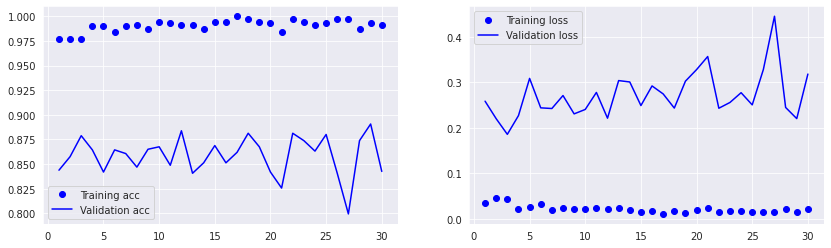

In [47]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [49]:
model_3_val = val_acc[-1]
accuracies.append(model_3_val)
print("Validation Accuracy: ", model_3_val)

Validation Accuracy:  0.8424999713897705


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f33903958d0>)

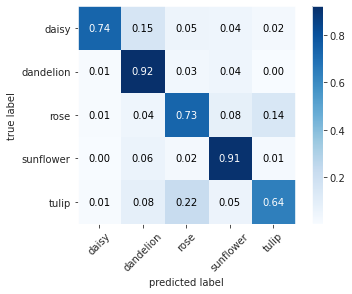

In [51]:
validation_generator.reset()
y_pred = model.predict_generator(validation_generator)
y_pred = y_pred.argmax(-1)
con_mat = tf.math.confusion_matrix(validation_generator.classes, y_pred)
con_mat = np.array(con_mat)
plot_confusion_matrix(conf_mat = con_mat, class_names = validation_generator.class_indices.keys(),colorbar=True,
                                show_absolute=False,
                                show_normed=True)

In [ ]:
plt.plot(accuracies) # plotting by columns
plt.show()